# Análisis y transformación de variables categóricas, clasificación y optimización (fine tuning) con redes neuronales – préstamos en instituciones bancarias

En esta práctica aprenderás a desarrollar y optimizar un clasificador mediante Redes Neuronales para predecir si un cliente en un banco es un cliente adecuado (BUENO, es decir, de bajo riesgo) o un cliente no adecuado (MALO, es decir, de alto riesgo) para concederle un crédito. Para ello, utilizaremos un Pipeline que es una herramienta que permite combinar transformadores, clasificadores, regresores u otros estimadores para construir un estimador compuesto. En el Pipeline integraremos pasos de transformación de variables y el clasificador. Además, aprenderás a evaluar y optimizar/ajustar (Tuning) los parámetros (hiperparámetros) del método mediante las funciones de cross_val_score, metrics y GridSearchCV. Finalmente, aprenderás a presentar los resultados en un Heatmap de tal manera que puedas indentificar visualmente los mejores valores de los parámetros.

En este ejemplo seguirás un proceso de análisis de datos en fases:

* Fase 1: preparación de datos
* Fase 2: entrenamiento base de una red neuronal
* Fase 3: optimización del modelo de red neuronal (Fine Tuning)
* Fase 4: predicción de nuevos samples (nuevos clientes)

## Fase 1: Preparación de datos

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config   

print("Módulos y clases importados")


Módulos y clases importados


Carga y descripción del dataset
Nombre del dataset: Statlog (German Credit Data). Enlace: http://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) [7].

Descripción general: este conjunto de datos clasifica a las personas descritas por un conjunto de atributos como riesgos crediticios buenos o malos.

Número de Variables (o atributos): 21

Número de instancias (clientes en el banco): 1000

Salida: TIPOCLIENTE (BUEN CLIENTE O BAJO RIESGO:1, MAL CLIENTE O ALTO RIESGO:2)

In [2]:
nombresVariables=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
                  'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
                  'ACTIVOS','EDAD','OTROSPLANESPAGO','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO',
                  'CANTIDADPERSONASAMANTENER','TELEFONO','TRABAJADOREXTRANJERO','TIPOCLIENTE']
#Cargar un dataframe desde una URL
dataframe = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', sep = ' ', 
                         names=nombresVariables)
#Cargar un dataframe de un archivo local
#dataset = "Datasets/german.data"
#dataframe = pd.read_csv(dataset, sep = ' ', names=nombresVariables)

print('cantidad de observaciones (clientes): ',dataframe.shape[0])
print('cantidad de variables: ',dataframe.shape[1])
print(dataframe.shape)
dataframe.head()

cantidad de observaciones (clientes):  1000
cantidad de variables:  21
(1000, 21)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Formato a la variable de salida

In [3]:
#Se modifica la variable de salida (de estudio): TIPOCLIENTE. Es mejor tener la salida en formato binario cuando hay dos clases
dataframe['TIPOCLIENTE'] = dataframe['TIPOCLIENTE'].replace(2, 0)
dataframe.head()

,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


### Eliminación de variables y separación de variable de salida

In [4]:
#Se separa la variable de salida "Y" para poder realizar la preparación de datos a las variables independiente "X" 
Y=dataframe['TIPOCLIENTE']
dataframe=dataframe.drop(['OTROSPLANESPAGO'], axis=1)
dataframe=dataframe.drop(['TELEFONO'], axis=1)
dataframe=dataframe.drop(['TIPOCLIENTE'], axis=1)
print(dataframe.shape)
dataframe.head()

(1000, 18)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A152,2,A173,1,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A152,1,A173,1,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A152,1,A172,2,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A153,1,A173,2,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A153,2,A173,2,A201


### Frecuencia de Clase

<Axes: xlabel='TIPOCLIENTE', ylabel='count'>

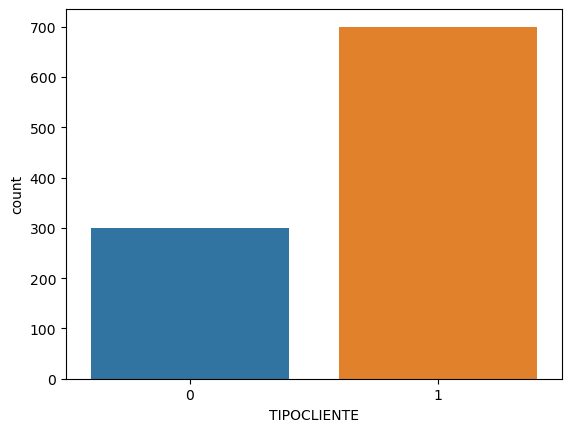

In [5]:
#Se genera una figura de frecuencia de clase, es decir, la cantidad de muestras en cada clase.
sns.countplot(x=Y)

### Análisis de variables categóricas

In [6]:
#Determinación de tipos de variables
categorical_ordinal_features = ['ESTADOCUENTACORRIENTE','HISTORIALCREDITO','SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO',
                                'ESTADOCIVILYSEXO','ACTIVOS','VIVIENDA','EMPLEO']
categorical_nominal_features = ['PROPOSITOCREDITO','GARANTE','TRABAJADOREXTRANJERO']
numeric_features = ['PLAZOMESESCREDITO','MONTOCREDITO','TASAPAGO','TIEMPORESIDENCIAACTUAL','EDAD','CANTIDADCREDITOSEXISTENTES',
                    'CANTIDADPERSONASAMANTENER']

In [7]:
def analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features):
    cantidadTotalVariables = len(dataframe.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadCategorias=dataframe[variable].nunique()
        cantidadVariablesBinarias=cantidadVariablesBinarias+cantidadCategorias
        print('Cantidad de categorías en la variable categórica nominal',variable,':',cantidadCategorias)
    print('Cantidad de variables binarias que reemplazarán a las variables categóricas nominales: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    return cantidadTotalVariablesConTransformacion

In [8]:
cantidadTotalVariablesConTransformacion=analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features)
print('Cantidad de variables que habrá después de la transformación de variables: ',cantidadTotalVariablesConTransformacion)

Cantidad de variables antes de transformación de variables:  18
Cantidad de categorías en la variable categórica nominal PROPOSITOCREDITO : 10
Cantidad de categorías en la variable categórica nominal GARANTE : 3
Cantidad de categorías en la variable categórica nominal TRABAJADOREXTRANJERO : 2
Cantidad de variables binarias que reemplazarán a las variables categóricas nominales:  15
Cantidad de variables que habrá después de la transformación de variables:  30


cantidadVariablesBinarias = 10+3+2=15 variables binarias en total

Las 3 variables categóricas nominales serán reemplazadas por las 15 variables binarias

Por lo tanto,

A las 18 variables iniciales se eliminarán las 3 variables categóricas nominales y se agregarán las 15 variables binarias.

18-3+15=30 variables

El dataframe luego de la transformación categórica a numérica tendrá 30 variables.

### Diseño de transformadores
Por medio de un Pipeline creamos un estimador compuesto. Esta herramienta nos permite combinar preprocesadores y transformadores para llevar un orden y estructura en el proceso de transformación de variables. Para una mejor organización creamos los preprocesadores y sus métodos de transformación.

In [9]:
#Definición de transformadores (preprocesadores)

#1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
categorical_ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())])
categorical_nominal_transformer_ConNombres = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida
preprocesorCategoricoNumericoConNombres = ColumnTransformer(
    transformers=[
        ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
        ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
    ],remainder='passthrough',n_jobs=-1)

#2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocesorMinMax = ColumnTransformer(transformers =[
    ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
standardscaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=True,with_std=True))])
preprocesorStandardScaler = ColumnTransformer(transformers =[
    ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#4. Preprocesador de variables numéricas con transformación SimpleImputer
simpleimputer_transformer = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='median')) #otras: strategy='constant', strategy='most_frequent'
])
preprocesorSimpleImputer = ColumnTransformer(transformers =[
('transimpleimputer', simpleimputer_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

### Diseño de pipeline
El procesador ‘prepcn’ es indispensable que se aplique antes de los demás preprocesadores numéricos. En el Pipeline “pipe” se aplica primeramente la tansformación de variables categóricas a variables numéricas y en segundo lugar se aplica la transformación numérica.

In [10]:
#Construcción de Pipeline con transformadores
pipe = Pipeline(steps=[
    ('prepcn', preprocesorCategoricoNumericoConNombres), 
    ('prepstandard', preprocesorStandardScaler)
    #('prepminmax', preprocesorMinMax)
])

### Transformación de variables

In [11]:
#Se ejecuta el pipeline
dataframeTransformado=copy.deepcopy(dataframe)
X_Transformado = pipe.fit_transform(dataframeTransformado)
print('********** Pipeline aplicado')
print('********** Transformador categórico nominal:')
print(pipe.named_steps['prepcn'].transformers_[1])
#Formación de dataframe transformado
cnamesDataset1=[]
if len(categorical_ordinal_features)!=0:
    cnamesDataset1.extend(categorical_ordinal_features)
if len(categorical_nominal_features)!=0:
    #nos ubicamos primeramente en el paso "prepcn" 
    #luego, en el transformador "catnom" que está en [1] y luego en "onehot", por eso [1][1] 
    cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
    cnamesDataset1.extend(cnamesDataset2)
cnamesDataset3 = numeric_features
cnamesDataset1.extend(cnamesDataset3)
print('********** Cantidad de variables:', len(cnamesDataset1))
print('********** Lista de variables:')
print(cnamesDataset1)
dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
#Guardar el dataset sin etiquetas como csv
dataframeTransformado.to_csv("DatasetTransformadoSinEtiquetas.csv", sep=";",index = False)
#Se agrega la variable de salida (etiquetas) al final
dataframeTransformado = pd.concat([dataframeTransformado, Y], axis = 1)
#Guardar el dataset con etiquetas como csv
dataframeTransformado.to_csv("DatasetTransformadoConEtiquetas.csv", sep=";",index = False)
dataframeTransformado.head()

********** Pipeline aplicado
********** Transformador categórico nominal:
('catnom', Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))]), ['PROPOSITOCREDITO', 'GARANTE', 'TRABAJADOREXTRANJERO'])
********** Cantidad de variables: 30
********** Lista de variables:
['ESTADOCUENTACORRIENTE', 'HISTORIALCREDITO', 'SALDOCUENTAAHORROS', 'TIEMPOACTUALEMPLEO', 'ESTADOCIVILYSEXO', 'ACTIVOS', 'VIVIENDA', 'EMPLEO', 'PROPOSITOCREDITO_A40', 'PROPOSITOCREDITO_A41', 'PROPOSITOCREDITO_A410', 'PROPOSITOCREDITO_A42', 'PROPOSITOCREDITO_A43', 'PROPOSITOCREDITO_A44', 'PROPOSITOCREDITO_A45', 'PROPOSITOCREDITO_A46', 'PROPOSITOCREDITO_A48', 'PROPOSITOCREDITO_A49', 'GARANTE_A101', 'GARANTE_A102', 'GARANTE_A103', 'TRABAJADOREXTRANJERO_A201', 'TRABAJADOREXTRANJERO_A202', 'PLAZOMESESCREDITO', 'MONTOCREDITO', 'TASAPAGO', 'TIEMPORESIDENCIAACTUAL', 'EDAD', 'CANTIDADCREDITOSEXISTENTES', 'CANTIDADPERSONASAMANTENER']


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,-1.254566,1.344014,1.833169,1.338078,0.449326,-1.293723,0.133710,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,1
1,-0.459026,-0.503428,-0.699707,-0.317959,-0.963650,-1.293723,0.133710,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,0
2,1.132053,1.344014,-0.699707,0.510060,0.449326,-1.293723,0.133710,-1.383771,-0.552705,-0.338862,...,0.196014,-0.196014,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,1
3,-1.254566,-0.503428,-0.699707,0.510060,0.449326,-0.341055,2.016956,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,1
4,-1.254566,0.420293,-0.699707,-0.317959,0.449326,1.564281,2.016956,0.146949,1.809283,-0.338862,...,0.196014,-0.196014,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0


In [12]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
guardarPipeline(pipe,'pipePreprocesadores')

## Fase 2: Entrenamiento base de una red neuronal

### Carga de pipeline de preparación del conjunto de datos

Se puede cargar un Pipeline creado previamente para la preparación de los datos de este dataset.

In [14]:
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

In [15]:
nombreArchivoPreprocesador='pipePreprocesadores'
pipe=None
pipe=cargarPipeline(nombreArchivoPreprocesador) #Debes incluir el archivo del Pipeline en el mismo directorio del script 
cantidadPasos=len(pipe.steps)
print("Cantidad de pasos: ",cantidadPasos)
set_config(display='diagram')
pipe

Cantidad de pasos:  2


Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['ESTADOCUENTACORRIENTE',
                                                   'HISTORIALCREDITO',
                                                   'SALDOCUENTAAHORROS',
                                                   'TIEMPOACTUALEMPLEO',
                                                   'ESTADOCIVILYSEXO',
                                                   'ACTIVOS', 'VIVIENDA',
                                                   'EMPLEO']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PROPOSITOCREDITO',
                                                   'GARANTE',
                                                   'TRABAJADOREXTRANJERO'])])),
                ('prepstandard',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transcaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28,
                                                   29])]))])

In [ ]:
#Funciones para guardar y cargar la Red Neuronal (Arquitectura y Pesos)
def guardarNN(model,nombreArchivo):
    print("Guardando Red Neuronal en Archivo")  
    model.save(nombreArchivo+'.h5')
    print("Red Neuronal Grabada en Archivo")   
    
def cargarNN(nombreArchivo):
    model = load_model(nombreArchivo+'.h5')    
    print("Red Neuronal Cargada desde Archivo") 
    return model